We begin with defining the example graph to be used. We then formulate the Ressource Constrained Shortest Path (RCSP) problem as a Mixed Integer Linear Program (MILP), and visualise the result. Then, a counterfactual is computed. For the rest of the computations, results are stored in a results file and only computed if needed. 

In [14]:
# Load libaries and define graph 
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

edges = [ # (source_node, target_node, objective, length)
    (1,2,4,2),(1,3,2,3),(2,4,2,2),(2,5,3,5),(3,5,4,1),(3,6,2,4),
    (4,7,3,2),(4,8,2,4),(5,8,1,2),(5,9,5,3),(6,9,2,2),(6,10,4,4),
    (7,11,2,1),(8,11,3,2),(8,12,2,3),(9,12,2,2),(10,12,1,3),
    (2,3,2,1),(5,6,3,2),(7,8,1,1),(9,10,2,2),(11,12,1,1)
]

source = 1
target = 12
length_limit = 8

In [15]:
# Solve CSP using MIP
def csp_mip(edges:list,source:int,sink:int,length_constraint:int,enforced:list=[],removed:list=[]):
    """Solve a constraint shortest path problem using MILP. Returns either a shortest path or False."""
    nodes = set([edge[0] for edge in edges]+[edge[1] for edge in edges])
    if source not in nodes or sink not in nodes:
        raise ValueError("Source or sink not in graph nodes.")
    else:
        # Create model
        m = gp.Model("constraint_shortest_path")

        # Add binary decision variables x[i,j] = 1 if edge (i,j) is used
        x = {}
        for i, j, f1, f2 in edges:
            x[i, j] = m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

        # Flow conservation constraints
        for k in nodes:
            inflow = gp.quicksum(x[i, k] for i, j, *_ in edges if j == k)
            outflow = gp.quicksum(x[k, j] for i, j, *_ in edges if i == k)
            if k == source:
                m.addConstr(outflow - inflow == 1, f"flow_out_{k}")
            elif k == sink:
                m.addConstr(inflow - outflow == 1, f"flow_in_{k}")
            else:
                m.addConstr(inflow - outflow == 0, f"flow_balance_{k}")

        # Length constraint
        m.addConstr(gp.quicksum(edges[index][3]*x[edges[index][0], edges[index][1]] for index in range(len(edges))) <= length_constraint)

        # Enforce specific edges to be included in the path
        for (i, j) in enforced:
            if (i, j) in x:
                m.addConstr(x[i, j] == 1, f"enforce_edge_{i}_{j}")
            else:
                raise ValueError(f"Edge ({i}, {j}) not in graph.")

        # Remove specific edges from the path    
        for (i, j) in removed:
            if (i, j) in x:
                m.addConstr(x[i, j] == 0, f"remove_edge_{i}_{j}")
            else:
                raise ValueError(f"Edge ({i}, {j}) not in graph.")

        # Objective
        m.setObjective(gp.quicksum(edges[index][2]*x[edges[index][0], edges[index][1]] for index in range(len(edges))), GRB.MINIMIZE)

        # Optimize
        m.optimize()

        # Print results
        if m.status == GRB.OPTIMAL:
            result = []
            print(f"\nOptimal objective value: {m.objVal:.2f}")
            print("Selected edges:")
            for (i, j, f1, f2) in edges:
                if x[i, j].x > 0.5:
                    print(f"  ({i}, {j})  obj1={f1}, obj2={f2}")
                    result.append((i, j))
            return result, m.objVal
        else: return False, None

result, objective = csp_mip(edges,1,12,8)
print("The shortest path is",result," with objective value",objective)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 13 rows, 22 columns and 66 nonzeros
Model fingerprint: 0xdb43ca40
Variable types: 0 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 12.0000000
Presolve removed 13 rows and 22 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 12 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.200000000000e+01, best bound 1.200000000000e+01, gap 0.0000%

Optimal objective value: 12.00
Selected edges:
  (1, 2)  obj1=4, obj2=2
  (2, 4)  obj1=2, obj2=2
  (4, 7)  obj1=3, obj2=2
  (7, 11)  obj1=2, obj2=1
 

C:\Users\Felix Engelhardt\AppData\Local\Temp\ipykernel_26084\4014768026.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


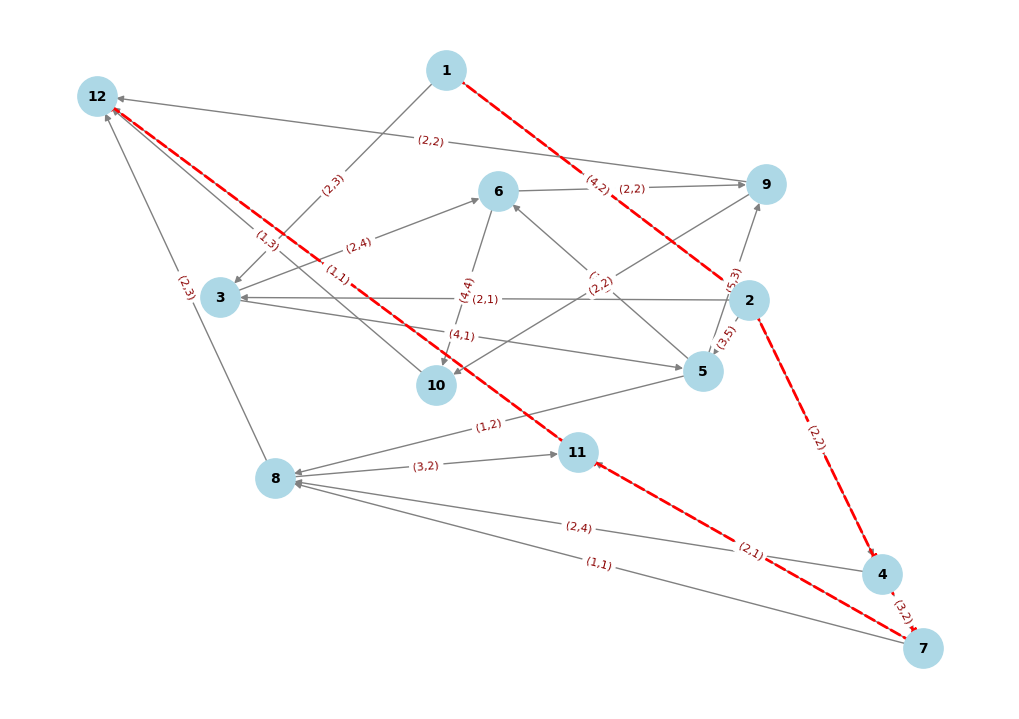

In [16]:
def plot_path(edges:list,path:list,otherpath:list=[]):
    """ Edges is a list of tuples (source_node, target_node, objective, length), path a list of (source_node, target_node) tuples."""
    G = nx.DiGraph()

    # Add edges with attributes
    for u, v, f1, f2 in edges:
        G.add_edge(u, v, obj1=f1, obj2=f2)

    # Define a layout for visualization
    pos = nx.spring_layout(G, seed=42, k=0.6)

    # Draw the graph
    plt.figure(figsize=(10,7))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color='lightblue',
        node_size=800,
        font_size=10,
        font_weight='bold',
        edge_color='gray'
    )

    # Create edge labels showing (obj1, obj2)
    edge_labels = {(u, v): f"({d['obj1']},{d['obj2']})" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(
        G, pos,
        edgelist=path,
        edge_color='red',
        width=2,
        style='--'
    )

    if otherpath != []:
        nx.draw_networkx_edges(
            G, pos,
            edgelist=otherpath,
            edge_color='green',
            width=2,
            style='--'
        )
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred', font_size=8)

    #plt.title("Ressource Constrained Shortest Path Problem", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_path(edges,result)

Now, we would like to modify weights so some edges not currently part of the solution become part of an/all optimal solutions. We pick the edge [1,2] to remove.

In [17]:
result, objective = csp_mip(edges,1,12,8,enforced=[],removed=[(1,2)])

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 14 rows, 22 columns and 67 nonzeros
Model fingerprint: 0x30a3ddc5
Variable types: 0 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Presolve removed 7 rows and 12 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -


However, there is no feasible RCSP that does not use this edge. Thus, we need to compute a counterfactual explanation: What is the least change to our weights, so that we get a preferred shortest path as the optimum? We start with a +/-1 deviation on lengths and compute a lower bound where we lower all weights by 1.

In [18]:
min_edges = [(edge[0],edge[1],edge[2],edge[3]-1) for edge in edges]
csp_mip(min_edges,1,12,8,enforced=[],removed=[(1,2)])
print("Cost of CE:",len(min_edges))

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 14 rows, 22 columns and 62 nonzeros
Model fingerprint: 0xe6fca62a
Variable types: 0 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 14.0000000
Presolve removed 14 rows and 22 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 8 14 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.000000000000e+00, best bound 8.000000000000e+00, gap 0.0000%

Optimal objective value: 8.00
Selected edges:
  (1, 3)  obj1=2, obj2=2
  (3, 6)  obj1=2, obj2=3
  (6, 9)  obj1=2, obj2=1
  (9, 12)  obj1=2, obj2=1


We see that the shortest path we can achieve is given by [(1, 3), (3, 6), (6, 9), (9, 12)] with SP-cost 8 and CE cost 22, if we reduce all lengths by 1. Now, we are interested in finguring out whether there is any cheaper CE with a lower CE-cost than 22.

For that, we iterate over all candidate objective values and solve the respective CE subproblem:

In [19]:
# Solve CSP using MIP
def ce_subproblem(edges:list,source:int,sink:int,length_constraint:int,target_objective:int,enforced:list=[],removed:list=[]):
    """Solve a CE subproblem using MILP. Returns either a modified set of weights or False."""
    nodes = set([edge[0] for edge in edges]+[edge[1] for edge in edges])
    if source not in nodes or sink not in nodes:
        raise ValueError("Source or sink not in graph nodes.")
    else:
        # Create model
        m = gp.Model("constraint_shortest_path with fixed objective")
        m.Params.OutputFlag = 0

        # Add binary decision variables x[i,j] = 1 if edge (i,j) is used
        x = {}
        for i, j, f1, f2 in edges:
            x[i, j] = m.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

        # Add auxilliary variables for the length deviations / tracking the objective
        length_devs_pos,length_devs_neg = {},{}
        for i, j, f1, f2 in edges:
            length_devs_pos[i, j] = m.addVar(vtype=GRB.BINARY, name=f"+dev_{i}_{j}")
            length_devs_neg[i, j] = m.addVar(vtype=GRB.BINARY, name=f"-dev_{i}_{j}")

        # Flow conservation constraints
        for k in nodes:
            inflow = gp.quicksum(x[i, k] for i, j, *_ in edges if j == k)
            outflow = gp.quicksum(x[k, j] for i, j, *_ in edges if i == k)
            if k == source:
                m.addConstr(outflow - inflow == 1, f"flow_out_{k}")
            elif k == sink:
                m.addConstr(inflow - outflow == 1, f"flow_in_{k}")
            else:
                m.addConstr(inflow - outflow == 0, f"flow_balance_{k}")

        # Length constraint
        m.addConstr(gp.quicksum((edges[index][3]+length_devs_pos[edges[index][0], edges[index][1]]-length_devs_neg[edges[index][0], edges[index][1]])*x[edges[index][0], edges[index][1]] for index in range(len(edges))) <= length_constraint)

        # Enforce specific edges to be included in the path
        for (i, j) in enforced:
            if (i, j) in x:
                m.addConstr(x[i, j] == 1, f"enforce_edge_{i}_{j}")
            else:
                raise ValueError(f"Edge ({i}, {j}) not in graph.")
        for (i, j) in removed:
            if (i, j) in x:
                m.addConstr(x[i, j] == 0, f"enforce_edge_{i}_{j}")
            else:
                raise ValueError(f"Edge ({i}, {j}) not in graph.")
            
        # SP-Objective Constraint
        m.addConstr(gp.quicksum(edges[index][2]*x[edges[index][0], edges[index][1]] for index in range(len(edges))) == target_objective)

        # Objective
        m.setObjective(gp.quicksum((length_devs_pos[edges[index][0], edges[index][1]]+length_devs_neg[edges[index][0], edges[index][1]]) for index in range(len(edges))), GRB.MINIMIZE)

        # Optimize
        m.optimize()
        if m.status == GRB.OPTIMAL: print("Initial optimization done. Starting separation procedure. SP Obj:",target_objective,"CE Cost:",m.objVal)
        else: 
            print("No feasible RCSP exists for the objective",target_objective)
            return False, None

        # If no solution was found, terminate. Otherwise, check whether there exists a cheaper path that is not in the desired solution space
        counter = 0
        while m.status == GRB.OPTIMAL:
            counter += 1    
            print("\nStart seperation iteration",counter)
            aux = gp.Model("check_for_cheaper_path")
            aux.Params.OutputFlag = 0
            
            # Add binary decision variables x[i,j] = 1 if edge (i,j) is used
            x_aux = {}
            for i, j, f1, f2 in edges:
                x_aux[i, j] = aux.addVar(vtype=GRB.BINARY, name=f"x_{i}_{j}")

            # Flow conservation constraints
            for k in nodes:
                inflow = gp.quicksum(x_aux[i, k] for i, j, *_ in edges if j == k)
                outflow = gp.quicksum(x_aux[k, j] for i, j, *_ in edges if i == k)
                if k == source:
                    aux.addConstr(outflow - inflow == 1, f"flow_out_{k}")
                elif k == sink:
                    aux.addConstr(inflow - outflow == 1, f"flow_in_{k}")
                else:
                    aux.addConstr(inflow - outflow == 0, f"flow_balance_{k}")

            # Length constraint
            weights = {index:(edges[index][3] + length_devs_pos[edges[index][0], edges[index][1]].x - length_devs_neg[edges[index][0], edges[index][1]].x) for index in range(len(edges))}
            aux.addConstr(gp.quicksum(weights[index]*x_aux[edges[index][0], edges[index][1]] for index in range(len(edges))) <= length_constraint)
            
            aux.setObjective(gp.quicksum(edges[index][2]*x_aux[edges[index][0], edges[index][1]] for index in range(len(edges))), GRB.MINIMIZE)

            aux.update()
            aux.optimize()

            if aux.status == GRB.OPTIMAL:
                better_sp = [(i,j) for (i, j, f1, f2) in edges if x_aux[i, j].x > 0.5]

                # Length constraint
                if aux.objVal <= target_objective -1:
                    print("Alternative/cheaper path found with cost",aux.objVal,"Constraint added")
                    m.addConstr(gp.quicksum((edges[index][3]+length_devs_pos[edges[index][0], edges[index][1]]-length_devs_neg[edges[index][0], edges[index][1]])*x[edges[index][0], edges[index][1]] for index in range(len(edges)) if (edges[index][0], edges[index][1]) in better_sp) >= length_constraint +1)
                    m.optimize()
                    print("Reoptimisation result:",m.status)
                else:
                    print("No cheaper path exists under the modified weights. CE found.",aux.objVal,target_objective,"\n")
                    return weights, m.objVal

        else: return False, None

best_result, best_objective = None, 1000
for obj_candidate in range(8,13):
    print("\n######################################################################################")
    print(f"Trying objective candidate: {obj_candidate}")
    ce_result, ce_objective = ce_subproblem(edges,1,12,8,obj_candidate,removed=[(1,2)])
    if ce_objective is not None:
        print(f"Found CE with objective {obj_candidate} and CE cost {ce_objective}")
        if ce_objective < best_objective:
            best_objective = ce_objective
            best_result = ce_result
            print("Improved incumbent to",best_objective,best_result)
    else: 
        print("NO CE found for objective candidate",obj_candidate,"\n")

print("Best CE:",best_objective,best_result)
        


######################################################################################
Trying objective candidate: 8
Initial optimization done. Starting separation procedure. SP Obj: 8 CE Cost: 3.0

Start seperation iteration 1
No cheaper path exists under the modified weights. CE found. 8.0 8 

Found CE with objective 8 and CE cost 3.0
Improved incumbent to 3.0 {0: 2.0, 1: 2.0, 2: 2.0, 3: 5.0, 4: 1.0, 5: 3.0, 6: 2.0, 7: 4.0, 8: 2.0, 9: 3.0, 10: 1.0, 11: 4.0, 12: 1.0, 13: 2.0, 14: 3.0, 15: 2.0, 16: 3.0, 17: 1.0, 18: 2.0, 19: 1.0, 20: 2.0, 21: 1.0}

######################################################################################
Trying objective candidate: 9
Initial optimization done. Starting separation procedure. SP Obj: 9 CE Cost: 1.0

Start seperation iteration 1
No cheaper path exists under the modified weights. CE found. 9.0 9 

Found CE with objective 9 and CE cost 1.0
Improved incumbent to 1.0 {0: 2.0, 1: 3.0, 2: 2.0, 3: 5.0, 4: 0.0, 5: 4.0, 6: 2.0, 7: 4.0, 8: 2.0, 9: 3.0

Thus, we find that the cheapest CE that ensures edge (1,2) is not taken is given through the weigths:  {0: 2.0, 1: 3.0, 2: 2.0, 3: 5.0, 4: 0.0, 5: 4.0, 6: 2.0, 7: 4.0, 8: 2.0, 9: 3.0, 10: 2.0, 11: 4.0, 12: 1.0, 13: 2.0, 14: 3.0, 15: 2.0, 16: 3.0, 17: 1.0, 18: 2.0, 19: 1.0, 20: 2.0, 21: 1.0} and costs 1.

We validate this using csp_mip.

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 13 rows, 22 columns and 65 nonzeros
Model fingerprint: 0x1b44490a
Variable types: 0 continuous, 22 integer (22 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+00]
Found heuristic solution: objective 12.0000000
Presolve removed 13 rows and 22 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 9 12 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.000000000000e+00, best bound 9.000000000000e+00, gap 0.0000%

Optimal objective value: 9.00
Selected edges:
  (1, 3)  obj1=2, obj2=3
  (3, 5)  obj1=4, obj2=0
  (5, 8)  obj1=1, obj2=2
  (8, 12)  obj1=2, obj2=3


C:\Users\Felix Engelhardt\AppData\Local\Temp\ipykernel_26084\4014768026.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


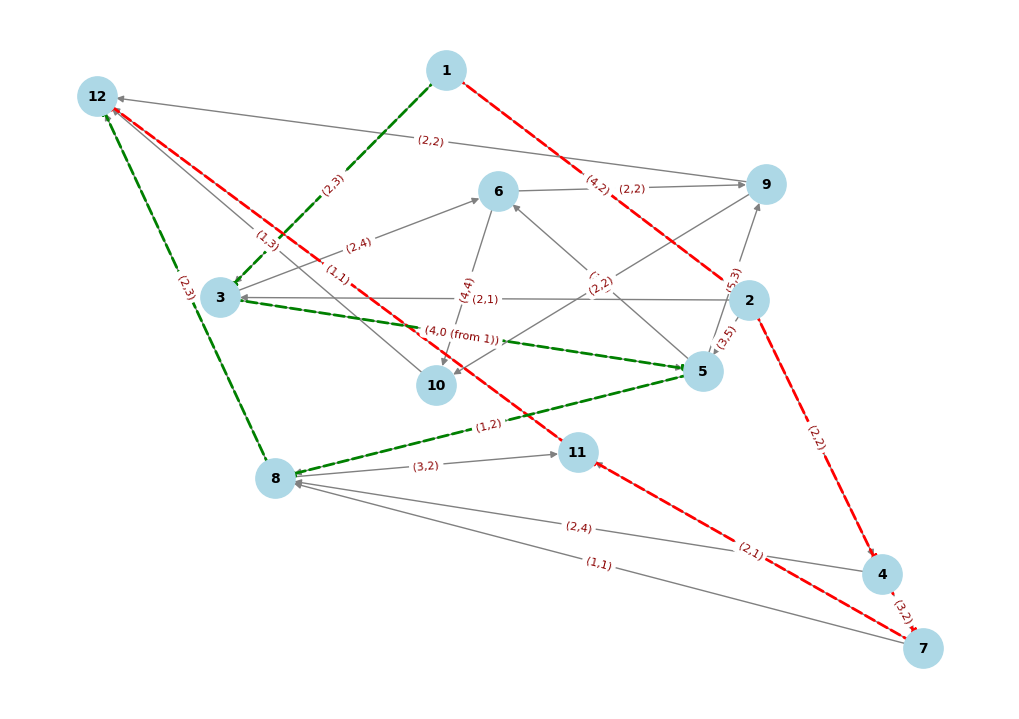

In [20]:
new_edges = [(edges[index][0],edges[index][1],edges[index][2],int(best_result[index])) for index in range(len(edges))]

new_result, new_objective = csp_mip(new_edges,1,12,8)
result, objective = csp_mip(edges,1,12,8)

for index in range(len(edges)):
    if int(best_result[index]) != edges[index][3]:
        print((edges[index][0],edges[index][1],edges[index][2],int(best_result[index])),edges[index][3])
        new_edges[index] = (edges[index][0],edges[index][1],edges[index][2],"0 (from 1)")

plot_path(new_edges,result,new_result)

Finally, we would like to check the solution to verify that we indeed did compute a correct counterfactual explanation.

In [21]:
def read_spprclib_instance(filename,factor=1000):
    """Reads in an SPPRCLIB instance."""

    with open(filename, 'r') as f:
        lines = f.readlines()
    
        linecounter = 7
        distances,demands = [],[]
        mode = 'matrix'
        while linecounter < len(lines):
            line = lines[linecounter].strip()
            linecounter += 1
            if line.startswith('NODE_WEIGHT_SECTION'):
                node_weights = [int(float(w)/factor) for w in lines[linecounter].strip().split()]
                linecounter += 1 # We are ignoring these
            elif line.startswith('CAPACITY'):
                capacity = int(line.strip().split()[-1])
            elif line.startswith('DEMAND_SECTION'):
                mode = 'demand'
            elif line.startswith('EOF'):
                break
            else:
                if mode == 'matrix':
                    row = [int(float(x)/factor) for x in line.split()]
                    distances.append(row)
                elif mode == 'demand':
                    demands.append(int(line.split()[-1]))

        return capacity,demands,distances,node_weights

# Usage example:
capacity,demands,distances,node_weights = read_spprclib_instance('data\\sppcc\\P-n101-k4-174.sppcc')

def csp_pricing_mip(distances:list,node_weights:list,demands:list,source:int,sink:int,capacity:int,enforced:list=[],removed:list=[],remove_node:list=[], printout=False):
    """Solve a constraint shortest path problem using MILP. Returns either a shortest path or False."""
    nodes = set(range(len(node_weights)))
    edge_tuples = [(node1,node2) for node1 in nodes for node2 in nodes if node1 < node2]
    if source not in nodes or sink not in nodes:
        raise ValueError("Source or sink not in graph nodes.")
    else:
        # Create model
        m = gp.Model("constraint_shortest_path")
        if not printout: m.Params.OutputFlag = 0

        # Add binary decision variables x[node1,node2] = 1 for each edge (node1,node2)
        x = {}
        for (node1,node2) in edge_tuples:
            x[node1,node2] = m.addVar(vtype=GRB.BINARY, name=f"x_{node1}_{node2}")

        # Flow conservation constraints
        for k in nodes:
            inflow = gp.quicksum(x[node1,node2] for (node1,node2) in edge_tuples if node2 == k)
            outflow = gp.quicksum(x[node1,node2] for (node1,node2) in edge_tuples if node1 == k)
            if k == source:
                m.addConstr(outflow - inflow == 1, f"flow_out_{k}")
            elif k == sink:
                m.addConstr(inflow - outflow == 1, f"flow_in_{k}")
            else:
                m.addConstr(inflow - outflow == 0, f"flow_balance_{k}")

        # Length constraint
        m.addConstr( gp.quicksum(1/2*(demands[node1]+demands[node2])*x[node1,node2] for (node1,node2) in edge_tuples) +1/2*demands[source]+1/2*demands[sink]<= capacity)
            
        # Enforce specific edges to be included in the path
        for (i, j) in enforced:
            if (i, j) in x:
                m.addConstr(x[i, j] == 1, f"enforce_edge_{i}_{j}")
            elif (j, i) in x:
                m.addConstr(x[j, i] == 1, f"enforce_edge_{j}_{i}")
            else:
                raise ValueError(f"Edge ({i}, {j}) not in graph.")

        # Remove specific edges from the path    
        for (i, j) in removed:
            if (i, j) in x:
                m.addConstr(x[i, j] == 0, f"remove_edge_{i}_{j}")
            elif (j, i) in x:
                m.addConstr(x[j, i] == 0, f"remove_edge_{j}_{i}")
            else:
                raise ValueError(f"Edge ({i}, {j}) not in graph.")
            
        # Remove specific nodes from the path    
        for node in remove_node:
            for (i, j) in x:
                if i == node:
                    m.addConstr(x[i, j] == 0, f"remove_node_{node} via edge {i}_{j}")
                elif j == node: 
                    m.addConstr(x[i, j] == 0, f"remove_node_{node} via edge {i}_{j}")
            print(f"Node {node} removed from path.")

        # Objective
        m.setObjective( gp.quicksum( distances[node1][node2]*x[node1,node2] for (node1,node2) in edge_tuples ) 
                       + 1/2*gp.quicksum( (node_weights[node1]+node_weights[node2])*x[node1,node2] for (node1,node2) in edge_tuples ) 
                       + 1/2*node_weights[source]+1/2*node_weights[sink] , GRB.MINIMIZE)

        # Optimize
        m.optimize()

        # Print results
        if m.status == GRB.OPTIMAL:
            result = []
            if printout: 
                print(f"\nOptimal objective value: {m.objVal:.2f}")
                print("Selected edges:")
            for (node1,node2) in edge_tuples:
                if x[node1,node2].x > 0.5:
                    if printout: print(f"  ({node1}, {node2})  obj1={distances[node1][node2]}, node weights: {node_weights[node1]},{node_weights[node2]}")
                    result.append((node1, node2))
            return result, int(m.objVal)
        elif m.status == GRB.INFEASIBLE:
            m.computeIIS()
            print("IIS found. Elements marked in IIS:")
            # constraints
            for c in m.getConstrs():
                if c.IISConstr:
                    print("  Constraint in IIS:", c.ConstrName)
            return False, None
        else: return False, None

# Usage example:
result, objective = csp_pricing_mip(distances,node_weights,demands,0,len(node_weights)-1,capacity,remove_node=[13])
print("The shortest path is now",result," with objective value",objective)

result, objective = csp_pricing_mip(distances,node_weights,demands,0,len(node_weights)-1,capacity)
print("The shortest path is now",result," with objective value",objective)

Node 13 removed from path.
The shortest path is now [(0, 6), (6, 59), (59, 85), (85, 91), (91, 100)]  with objective value 3
The shortest path is now [(0, 13), (13, 59), (59, 85), (85, 91), (91, 100)]  with objective value 2


In [22]:
from math import ceil

def ce_subproblem(distances:list,node_weights:list,demands:list,source:int,sink:int,capacity:int,target_objective:int,remove_node:list=[],constraints:list=[],percentage_deviation:int=10):
    """Solve a CE subproblem using MILP. Returns either a modified set of weights or False."""
    nodes = set(range(len(node_weights)))
    edge_tuples = [(node1,node2) for node1 in nodes for node2 in nodes if node1 < node2]
    if source not in nodes or sink not in nodes:
        raise ValueError("Source or sink not in graph nodes.")
    else:
        # Create model
        m = gp.Model("constraint_shortest_path with fixed objective")
        m.Params.OutputFlag = 0

        # Add binary decision variables x[node1,node2] = 1 for each edge (node1,node2)
        x = {}
        for (node1,node2) in edge_tuples:
            x[node1,node2] = m.addVar(vtype=GRB.BINARY, name=f"x_{node1}_{node2}")

        # Add auxilliary variables for the length deviations / tracking the objective
        length_devs_pos,length_devs_neg = {},{}
        for node in nodes:
            length_devs_pos[node] = m.addVar(vtype=GRB.INTEGER, name=f"+dev_{node}",ub=demands[node]*percentage_deviation/100.0,lb=0)
            length_devs_neg[node] = m.addVar(vtype=GRB.INTEGER, name=f"-dev_{node}",ub=demands[node]*percentage_deviation/100.0,lb=0)

        # Flow conservation constraints
        for k in nodes:
            inflow = gp.quicksum(x[node1,node2] for (node1,node2) in edge_tuples if node2 == k)
            outflow = gp.quicksum(x[node1,node2] for (node1,node2) in edge_tuples if node1 == k)
            if k == source:
                m.addConstr(outflow - inflow == 1, f"flow_out_{k}")
            elif k == sink:
                m.addConstr(inflow - outflow == 1, f"flow_in_{k}")
            else:
                m.addConstr(inflow - outflow == 0, f"flow_balance_{k}")

        # Length constraint
        m.addConstr( gp.quicksum(1/2*(demands[node1]+demands[node2]+length_devs_pos[node1]+length_devs_pos[node2]-length_devs_neg[node1]-length_devs_neg[node2])*x[node1,node2] for (node1,node2) in edge_tuples) 
                    +1/2*(demands[source]+demands[sink] -length_devs_neg[source]-length_devs_neg[sink]+length_devs_pos[source]+length_devs_pos[sink])<= capacity)
            
        # Remove specific nodes from the path    
        for node in remove_node:
            for (i, j) in x:
                if i == node:
                    m.addConstr(x[i, j] == 0, f"remove_node_{node} via edge {i}_{j}")
                elif j == node: 
                    m.addConstr(x[i, j] == 0, f"remove_node_{node} via edge {i}_{j}")

        # SP-Objective Constraint
        old_objective = gp.quicksum( distances[node1][node2]*x[node1,node2] for (node1,node2) in edge_tuples ) + 1/2*gp.quicksum( (node_weights[node1]+node_weights[node2])*x[node1,node2] for (node1,node2) in edge_tuples ) + 1/2*node_weights[source]+1/2*node_weights[sink]
        m.addConstr(old_objective == target_objective)

        # Constraints from previous iterations
        for cons in constraints:
            m.addConstr( gp.quicksum(1/2*(demands[node1]+demands[node2]+length_devs_pos[node1]+length_devs_pos[node2]-length_devs_neg[node1]-length_devs_neg[node2])*x[node1,node2] for (node1,node2) in cons) 
            +1/2*(demands[source]+demands[source]-length_devs_neg[source]-length_devs_neg[sink]+length_devs_pos[source]+length_devs_pos[sink]) >= capacity +1)  

        # Objective
        m.setObjective(gp.quicksum((length_devs_pos[node]+length_devs_neg[node]) for node in nodes), GRB.MINIMIZE)

        # Optimize
        m.optimize()
        if m.status == GRB.OPTIMAL: 
            print("Initial optimization done. Starting separation procedure. SP Obj:",target_objective,"CE Cost:",m.objVal)

        else: 
            print("No feasible RCSP in the favoured domain exists for the objective",target_objective)
            return False, None, constraints

        # If no solution was found, terminate. Otherwise, check whether there exists a cheaper path that is not in the desired solution space
        counter = 0
        while m.status == GRB.OPTIMAL:
            counter += 1    
            print("\nStart seperation iteration",counter)
            aux = gp.Model("check_for_cheaper_path")
            aux.Params.OutputFlag = 0
            
            # Add binary decision variables x[i,j] = 1 if edge (i,j) is used
            x_aux = {}
            for (node1,node2) in edge_tuples:
                x_aux[node1,node2] = aux.addVar(vtype=GRB.BINARY, name=f"x_aux_{node1}_{node2}")

            # Flow conservation constraints
            for k in nodes:
                inflow = gp.quicksum(x_aux[node1,node2] for (node1,node2) in edge_tuples if node2 == k)
                outflow = gp.quicksum(x_aux[node1,node2] for (node1,node2) in edge_tuples if node1 == k)
                if k == source:
                    aux.addConstr(outflow - inflow == 1, f"flow_out_{k}")
                elif k == sink:
                    aux.addConstr(inflow - outflow == 1, f"flow_in_{k}")
                else:
                    aux.addConstr(inflow - outflow == 0, f"flow_balance_{k}")

            # Length constraint
            aux.addConstr( gp.quicksum(1/2*(demands[node1]+demands[node2]+length_devs_pos[node1].x+length_devs_pos[node2].x-length_devs_neg[node1].x-length_devs_neg[node2].x)*x_aux[node1,node2] for (node1,node2) in edge_tuples) 
                    +1/2*(demands[source]+demands[sink]-length_devs_neg[source].x-length_devs_neg[sink].x+length_devs_pos[source].x+length_devs_pos[sink].x)<= capacity)

            aux.setObjective(gp.quicksum( distances[node1][node2]*x_aux[node1,node2] for (node1,node2) in edge_tuples ) + 1/2*gp.quicksum( (node_weights[node1]+node_weights[node2])*x_aux[node1,node2] for (node1,node2) in edge_tuples ) + 1/2*node_weights[source]+1/2*node_weights[sink], GRB.MINIMIZE)

            aux.update()
            aux.optimize()

            if aux.status == GRB.OPTIMAL:
                better_sp = [(i,j) for (i,j) in edge_tuples if x_aux[i, j].x > 0.5]

                # Length constraint
                if aux.objVal <= target_objective -1:
                    print("Alternative/cheaper path found with cost",aux.objVal,"Constraint added",better_sp)
                    m.addConstr( gp.quicksum(1/2*(demands[node1]+demands[node2]+length_devs_pos[node1].x+length_devs_pos[node2].x-length_devs_neg[node1].x-length_devs_neg[node2].x)*x[node1,node2] for (node1,node2) in better_sp) 
                    +1/2*(demands[source]+demands[source] -length_devs_neg[source].x-length_devs_neg[sink].x+length_devs_pos[source].x+length_devs_pos[sink].x) >= capacity +1)
                    constraints.append(better_sp)
                    m.optimize()
                    print("Reoptimisation result:",m.status)
                else:
                    print("No cheaper path exists under the modified weights. CE found.",aux.objVal,target_objective,"\n")
                    weights = {node:(demands[node] + length_devs_pos[node].x - length_devs_neg[node].x) for node in nodes}
                    return weights, int(m.objVal), constraints
            else:
                print("No cheaper path exists under the modified weights. CE found. Aux infeasible.\n")
                weights = {node:(demands[node] + length_devs_pos[node].x - length_devs_neg[node].x) for node in nodes}
                return weights, int(m.objVal), constraints

        else: return False, None, constraints


def computeCE(distances,node_weights,demands,capacity,percentage_deviation=10):
    result, objective = csp_pricing_mip(distances,node_weights,demands,0,len(node_weights)-1,capacity)

    # Check CE
    resultCE, objectiveCE = csp_pricing_mip(distances,node_weights,demands,0,len(node_weights)-1,capacity,remove_node=[result[0][1]])
    if objectiveCE <= objective:
        print("Current solution is already a CE.",resultCE,objectiveCE)
        return demands, 0, "Not needed since incumbent is already CE."
    else:
        print("Starting CE search. Original cost {} vs favoured domain cost {}".format(objective,objectiveCE))
        resultLB, objectiveLB = csp_pricing_mip(distances,node_weights,[demand*(100-percentage_deviation)/100.0 for demand in demands],0,len(node_weights)-1,capacity)
        resultUB, objectiveUB = csp_pricing_mip(distances,node_weights,[demand*(100+percentage_deviation)/100.0 for demand in demands],0,len(node_weights)-1,capacity)
        print("Objective bounds for CE search:",objectiveLB,objectiveUB)

        constraints = []
        best_result, best_objective = None, 1000
        for obj_candidate in range(objectiveLB,objectiveUB):
            print(f"\nTrying objective candidate: {obj_candidate}")

            ce_result, ce_objective, constraints = ce_subproblem(distances,node_weights,demands,0,len(node_weights)-1,capacity,obj_candidate,remove_node=[result[0][1]],constraints=constraints,percentage_deviation=percentage_deviation)
            if ce_objective is not None:
                print(f"Found CE with objective {obj_candidate} and CE cost {ce_objective}")
                if ce_objective < best_objective:
                    best_objective = ce_objective
                    best_result = ce_result
                    print("Improved incumbent to",best_objective,best_result)
            else: 
                print("No CE found for objective candidate",obj_candidate,"\n")

        if best_result is not None:
            print("Best CE:",best_objective,best_result)
        else:
            print("No CE found in the given bounds.")
        return best_result, best_objective, constraints
    


In [23]:
print("\n\n########################### COMPUTE CE FOR SPPRCLIB INSTANCE ###########################\n\n")
capacity, demands, distances, node_weights  = read_spprclib_instance('data\\sppcc\\B-n78-k10-70.sppcc')
best_result, best_objective, constraints = computeCE(distances,node_weights,demands,capacity,percentage_deviation=20)




########################### COMPUTE CE FOR SPPRCLIB INSTANCE ###########################


Node 23 removed from path.
Starting CE search. Original cost -28 vs favoured domain cost -21
Objective bounds for CE search: -28 -28
No CE found in the given bounds.


In [24]:
import os
from time import time
from json import dump, load

# Folder containing the .sppcc files
folder = r"data\sppcc"

old_results = {}
if os.path.exists("results\ce_results.json"):
    with open("results\ce_results.json", "r") as f:
        old_results = load(f)

counter = 0
results = {}
n = []

for filename in os.listdir(folder):
    # Process only .sppcc files (remove this filter if you want all files)
    if filename.lower().endswith(".sppcc"):
        counter += 1
        
        path = os.path.join(folder, filename)
        print(f"\nReading {path}")

        capacity, demands, distances, node_weights = read_spprclib_instance(path)
        result, objective = csp_pricing_mip(distances,node_weights,demands,0,len(node_weights)-1,capacity)
        
        n.append(len(node_weights))

        if len(result) == 1:
                print("Trivial shortest path only contains source and sink. No CE possible.")
                results[filename] = {
                "initial_objective": objective,
                "ce_objective": "Trivial shortest path only contains source and sink. No CE possible.",
                "computation_time_seconds": 0,
                "best_result": None, 
                "best_objective": None,
                "constraints_added": None
            }  
        else:
            if filename in old_results and type(old_results[filename]['best_result']) is not list:
                print(f"\nSkipping {filename}, already processed.",type(old_results[filename]['best_result']))
                results[filename] = old_results[filename]
                continue
            start_time = time()
            best_result, best_objective, constraints =computeCE(distances,node_weights,demands,capacity,percentage_deviation=10)
            end_time = time()
            results[filename] = {
                "initial_objective": objective,
                "ce_objective": best_objective,
                "computation_time_seconds": end_time - start_time,
                "best_result": best_result, 
                "best_objective": best_objective,
                "constraints_added": constraints
            }   

        # Save results to a JSON file
        with open("results\ce_results.json", "w") as f:
            dump(results, f, indent=4)

print("\n\nProcessed",counter,"instances with average n =",sum(n)/len(n),n)



Reading data\sppcc\A-n54-k7-149.sppcc

Skipping A-n54-k7-149.sppcc, already processed. <class 'dict'>

Reading data\sppcc\A-n60-k9-57.sppcc

Skipping A-n60-k9-57.sppcc, already processed. <class 'NoneType'>

Reading data\sppcc\A-n61-k9-80.sppcc

Skipping A-n61-k9-80.sppcc, already processed. <class 'dict'>

Reading data\sppcc\A-n62-k8-99.sppcc

Skipping A-n62-k8-99.sppcc, already processed. <class 'NoneType'>

Reading data\sppcc\A-n63-k10-44.sppcc

Skipping A-n63-k10-44.sppcc, already processed. <class 'NoneType'>

Reading data\sppcc\A-n63-k9-157.sppcc

Skipping A-n63-k9-157.sppcc, already processed. <class 'dict'>

Reading data\sppcc\A-n64-k9-45.sppcc

Skipping A-n64-k9-45.sppcc, already processed. <class 'dict'>

Reading data\sppcc\A-n65-k9-10.sppcc
Node 15 removed from path.
Current solution is already a CE. [(0, 6), (6, 26), (26, 31), (31, 34), (34, 46), (46, 64)] -3

Reading data\sppcc\A-n69-k9-42.sppcc

Skipping A-n69-k9-42.sppcc, already processed. <class 'NoneType'>

Reading d

In [27]:
nofound = 0
trivial = 0
found = 0
CE_costs,times = [],[]
deltas = []

if os.path.exists("results\ce_results.json"):
    with open("results\ce_results.json", "r") as f:
        old_results = load(f)
        for key in old_results:
            print(f"{key}: Initial Obj {old_results[key]['initial_objective']}, Time {old_results[key]['computation_time_seconds']:.2f}s")
            if old_results[key]['ce_objective'] != 1000:
                print(f"  Best CE Objective: {old_results[key]['best_objective']}")
                if old_results[key]['ce_objective'] != 0:
                    found += 1
                else:
                    trivial += 1
            else: 
                print("  No CE found.")
                nofound += 1
            
            if old_results[key]['best_result'] is not None:
                #print(f"  Best Result Edges: {old_results[key]['best_result']}")
                if old_results[key]['constraints_added'] is not None:
                    print(f"  Number of Constraints Added: {len(old_results[key]['constraints_added'])}")
                    capacity, demands, distances, node_weights = read_spprclib_instance(os.path.join(folder, key))
                    result, objective = csp_pricing_mip(distances,node_weights,demands,0,len(node_weights)-1,capacity)
                    new_demands = [old_results[key]['best_result'][i] for i in old_results[key]['best_result']]
                    resultCE, objectiveCE = csp_pricing_mip(distances,node_weights,new_demands,0,len(node_weights)-1,capacity)
                    resultCE_forced, objectiveCE_forced = csp_pricing_mip(distances,node_weights,new_demands,0,len(node_weights)-1,capacity,remove_node=[result[0][1]])
                    print(result,objective)
                    print(resultCE, objectiveCE )
                    print(resultCE_forced, objectiveCE_forced )
                    CE_costs.append(old_results[key]['best_objective'])
                    times.append(old_results[key]['computation_time_seconds'])
                    deltas.append((objective - objectiveCE_forced)/max(1,objective,-objective,-objectiveCE_forced,objectiveCE_forced))
            print()

print("Summary of CE results:"
      f"\n  CE Found: {found}"
      f"\n  No CE Found: {nofound}"
      f"\n  Trivial CE: {trivial}"
      )

print("CE Costs Statistics:"
      f"\n  Average CE Cost: {sum(CE_costs)/len(CE_costs) if len(CE_costs)>0 else 0}"
      f"\n  Min CE Cost: {min(CE_costs) if len(CE_costs)>0 else 0}"
      f"\n  Max CE Cost: {max(CE_costs) if len(CE_costs)>0 else 0}"
      f"\n Std Dev CE Cost: {stdev(CE_costs) if len(CE_costs)>1 else 0}"
      )

print("Computation Time Statistics (seconds):"
      f"\n  Average Time: {sum(times)/len(times) if len(times)>0 else 0}"
      f"\n  Min Time: {min(times) if len(times)>0 else 0}"
      f"\n  Max Time: {max(times) if len(times)>0 else 0}"
      f"\n  Std Dev Time: {stdev(times) if len(times)>1 else 0}"
      )

from statistics import stdev
print("Objective Delta Statistics:"
      f"\n  Average Delta: {sum(deltas)/len(deltas) if len(deltas)>0 else 0}"
      f"\n  Min Delta: {min(deltas) if len(deltas)>0 else 0}"
      f"\n  Max Delta: {max(deltas) if len(deltas)>0 else 0}"
      f"\n  Std Dev Delta: {stdev(deltas) if len(deltas)>1 else 0}"
      )

A-n54-k7-149.sppcc: Initial Obj -72, Time 4.04s
  Best CE Objective: 2
  Number of Constraints Added: 1
Node 15 removed from path.
[(0, 15), (15, 17), (17, 38), (38, 44), (44, 53)] -72
[(0, 6), (6, 11), (11, 38), (38, 44), (44, 53)] -74
[(0, 6), (6, 11), (11, 38), (38, 44), (44, 53)] -74

A-n60-k9-57.sppcc: Initial Obj -29, Time 5.41s
  No CE found.

A-n61-k9-80.sppcc: Initial Obj -4, Time 7.50s
  Best CE Objective: 2
  Number of Constraints Added: 1
Node 1 removed from path.
[(0, 1), (1, 11), (11, 31), (31, 52), (52, 57), (57, 60)] -4
[(0, 9), (9, 11), (11, 28), (28, 31), (31, 52), (52, 57), (57, 60)] -4
[(0, 9), (9, 11), (11, 28), (28, 31), (31, 52), (52, 57), (57, 60)] -4

A-n62-k8-99.sppcc: Initial Obj -34, Time 12.03s
  No CE found.

A-n63-k10-44.sppcc: Initial Obj -23, Time 4.88s
  No CE found.

A-n63-k9-157.sppcc: Initial Obj -86, Time 5.62s
  Best CE Objective: 5
  Number of Constraints Added: 1
Node 3 removed from path.
[(0, 3), (3, 9), (9, 38), (38, 43), (43, 47), (47, 62)] -